In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

%matplotlib inline

In [2]:
df = pd.read_csv('ebw_data.csv')
df.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


## Описательная статистика

In [3]:
df.shape

(72, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


In [6]:
df.describe()

#Большой разброс среднего значения. Следует номрализовать данные (дополнительно это подтвержается на нижеприведённых графиках)

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


In [7]:
df.isna().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

In [8]:
df.nunique()

#в связи с измерением шва в 4 проекциях было приянто решение не кодировать категориальные признаки

IW        7
IF        8
VW        5
FP        5
Depth    29
Width    25
dtype: int64

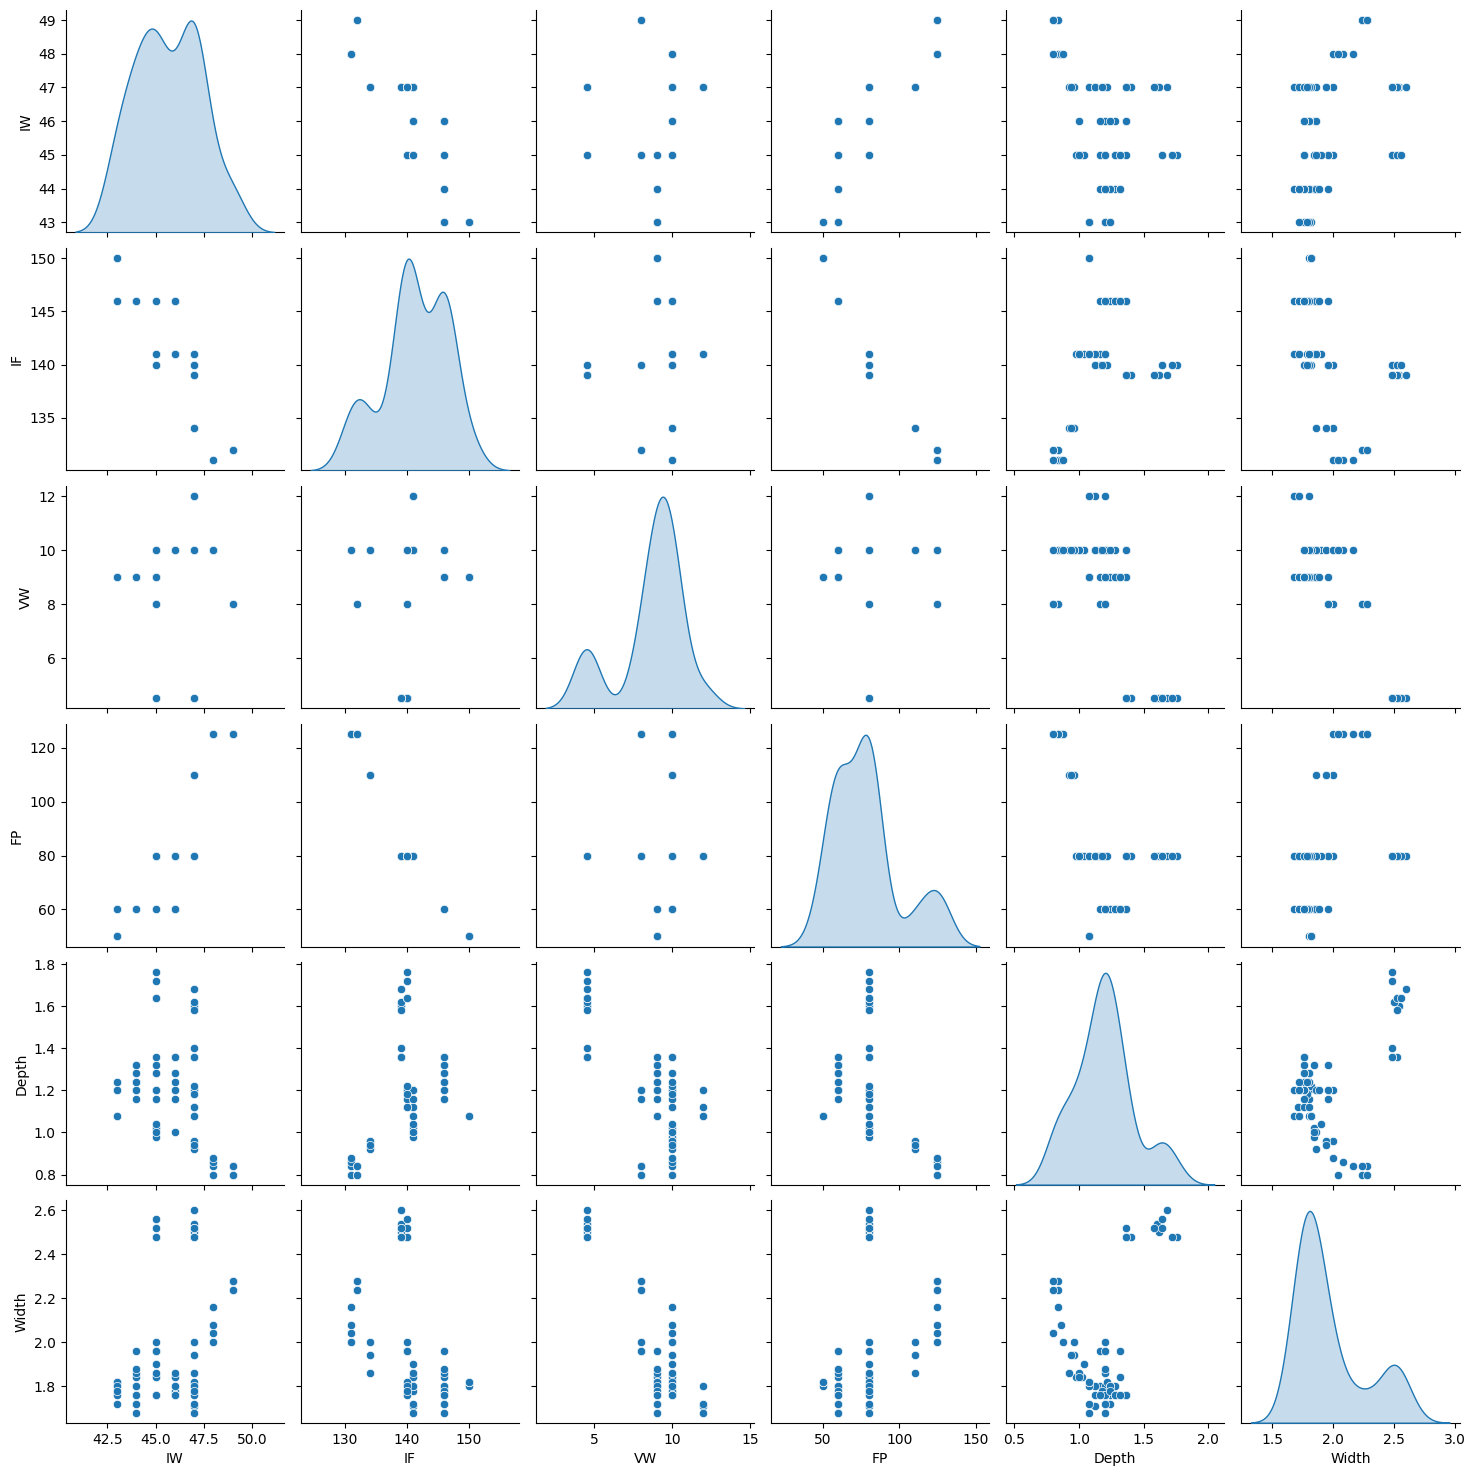

In [10]:
sns.pairplot(df, diag_kind = 'kde')

# попарные граффики рассеивания

In [11]:
def plot_hist(df, columns, n_rows, n_cols):
        
    fig=plt.figure(figsize=(15, 10))
    for i, var_name in enumerate(columns):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        sns.histplot(data=df, x=var_name, kde=True)
    

    plt.show()

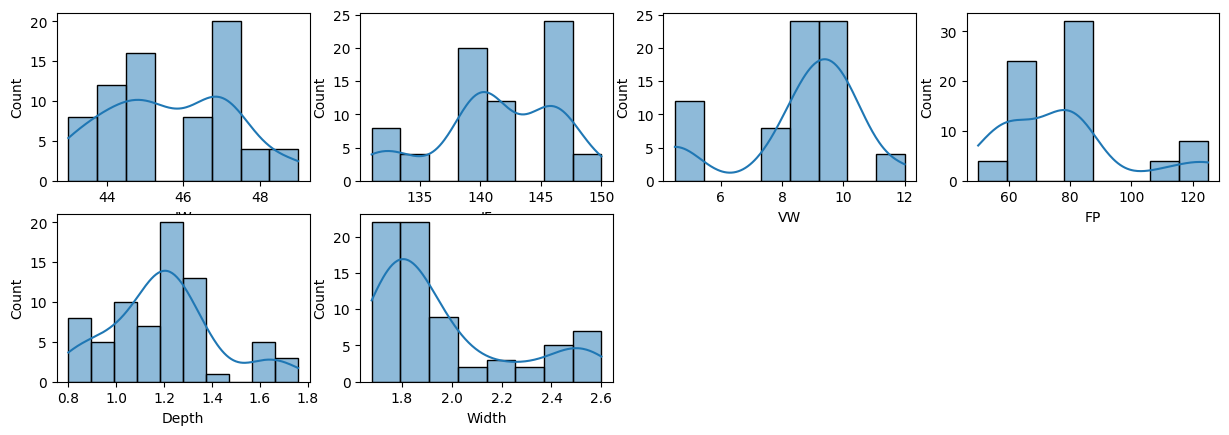

In [12]:
plot_hist(df, df.columns, 4, 4)

Text(0.5, 1.0, 'График оценки плотности ядра')

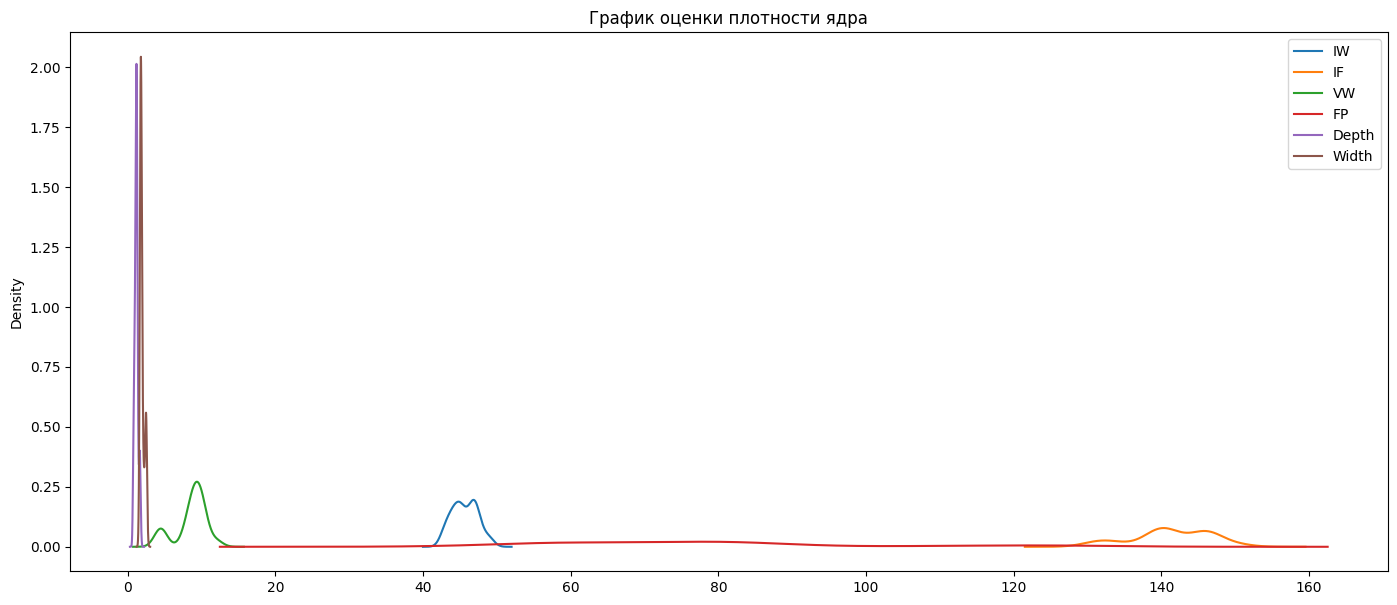

In [93]:
fig, ax = plt.subplots(figsize=(17, 7))
df.plot(kind='kde', ax=ax)
plt.title('График оценки плотности ядра')


In [14]:
# Из 2 вышеприведённых графиков следует, что нужно производить нормализацию значений, 
# так как данные находятся в разных диапазонах.

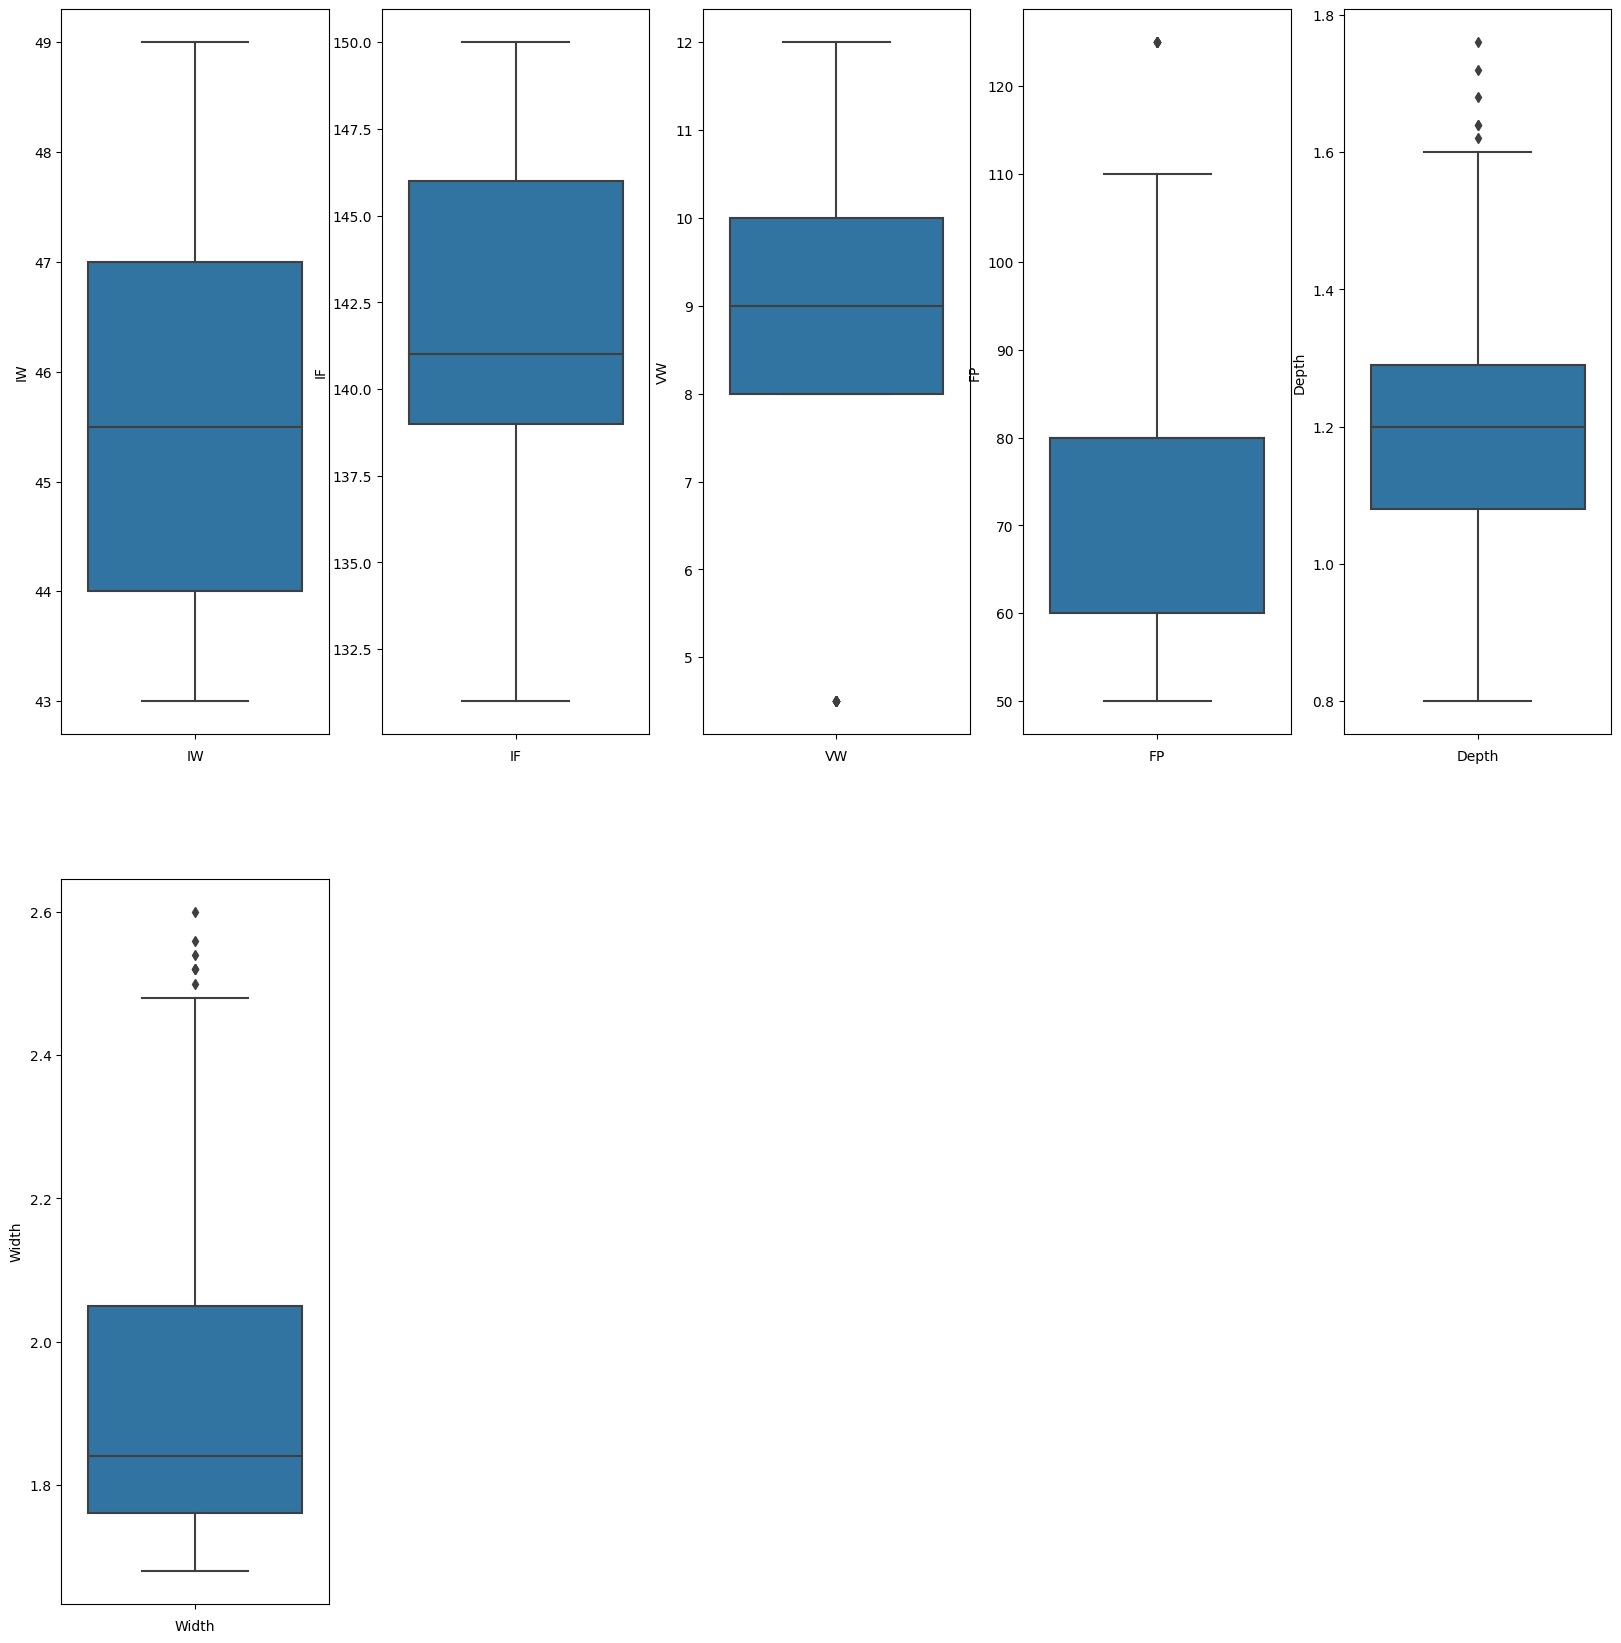

In [98]:
n = 1 # счетчик
s = 3 # строки
c = 5 # столбцы
fig = plt.figure(figsize=(20, 32))
for i in df.columns:
    plt.subplot(s, c, n)
    plt.xlabel(i)
    sns.boxplot(y = df[i])
    n = n + 1

plt.show()

# Из графика следует, что в наборе данных есть выбросы.
# Далее осуществляется проверка отдалённости выброса относительно оснвной массы данных.
# Проверка нахождения выбросов в диапазоне проводится с помощью метода 3 сигм.

In [16]:
sgm = 0
iqd= 0
for column in df:
    d = df.loc[:, [column]]
 # методом 3-х сигм
    zscore = (df[column] - df[column].mean()) / df[column].std()
    d['3s'] = zscore.abs() > 3
    sgm += d['3s'].sum()
print('Всего выбросов',sgm)

Всего выбросов 0


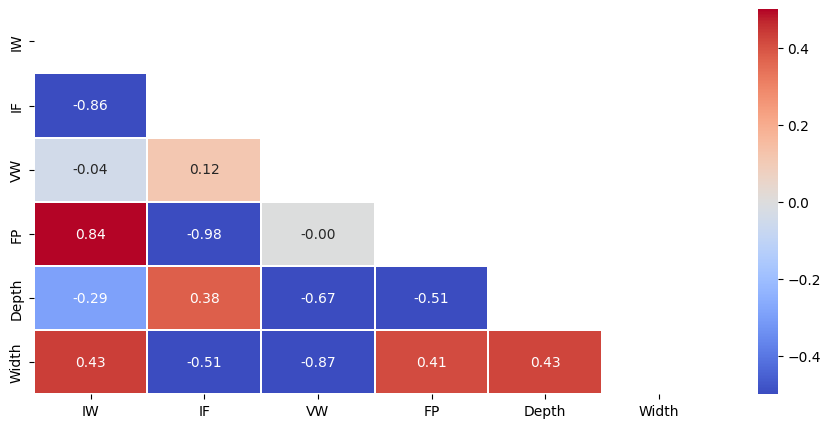

In [81]:
matrix = np.triu(df.corr())
fig = plt.subplots(figsize=(11, 5))
sns.heatmap(df.corr(), vmin=-0.5, vmax=0.5,  annot=True,fmt='.2f',cmap='coolwarm',  linewidths = 0.1,mask=matrix)
plt.show()

#Наиболее значимая обратная линейная зависимость у параметров ширины и глубины наблюдается с скоростью сварки (VW)

# Нормализация

In [18]:
col = df.columns
minmax = MinMaxScaler()
di = minmax.fit_transform(np.array(df))
dn = pd.DataFrame(data = di, columns = col)
dn.head()

,IW,IF,VW,FP,Depth,Width
0,0.666667,0.421053,0.0,0.4,0.833333,0.934783
1,0.666667,0.421053,0.0,0.4,0.854167,0.891304
2,0.666667,0.421053,0.0,0.4,0.916667,1.000000
3,0.666667,0.421053,0.0,0.4,0.812500,0.913043
4,0.333333,0.473684,0.0,0.4,1.000000,0.869565


In [19]:
dn.describe()

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,0.444444,0.543860,0.551852,0.377778,0.412037,0.315670
std,0.279727,0.270830,0.274810,0.286580,0.234460,0.303304
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166667,0.421053,0.466667,0.133333,0.291667,0.086957
50%,0.416667,0.526316,0.600000,0.400000,0.416667,0.173913
75%,0.666667,0.789474,0.733333,0.400000,0.510417,0.402174
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'График оценки плотности ядра после нормализации')

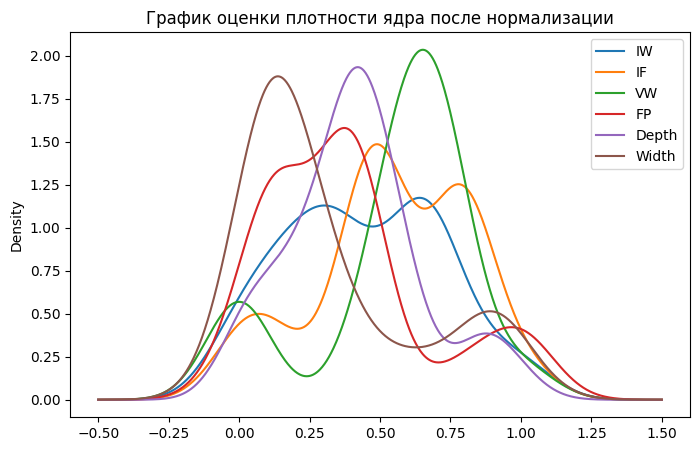

In [99]:
fig, ax = plt.subplots(figsize=(8, 5))
dn.plot(kind='kde', ax=ax)
plt.title('График оценки плотности ядра после нормализации')

## Разделение выборок

In [21]:
dn.head()

,IW,IF,VW,FP,Depth,Width
0,0.666667,0.421053,0.0,0.4,0.833333,0.934783
1,0.666667,0.421053,0.0,0.4,0.854167,0.891304
2,0.666667,0.421053,0.0,0.4,0.916667,1.000000
3,0.666667,0.421053,0.0,0.4,0.812500,0.913043
4,0.333333,0.473684,0.0,0.4,1.000000,0.869565


In [22]:
test_depth = dn['Depth']
t_d = dn.loc[:,dn.columns != 'Depth']
train_depth = t_d.loc[:,t_d.columns != 'Width']

X_train_depth, X_test_depth, y_train_depth, y_test_depth = train_test_split(train_depth, test_depth , test_size=0.25, random_state=42)

In [23]:
test_width = dn['Width']
t_w = dn.loc[:,dn.columns != 'Depth']
train_width = t_w.loc[:,t_d.columns != 'Width']

X_train_width, X_test_width, y_train_width, y_test_width = train_test_split(train_width, test_width , test_size=0.25, random_state=42)

In [24]:
# функция для отрисовки графиков действительных и предсказанных значений

def actual_and_predicted_plot(orig, predict, var, model_name):
    plt.figure(figsize=(17,5))
    plt.title(f'Тестовые и прогнозные значения: {model_name}')
    plt.plot(orig, label='Тест')
    plt.plot(predict, label='Прогноз')
    plt.legend(loc='best')
    plt.ylabel(var)
    plt.xlabel('Количество наблюдений')
    plt.show()

# 1) Алгоритм k - ближайших соседей

In [25]:
knr_model = KNeighborsRegressor()

## 1.1) Для глубины

In [26]:
neigh_params = {'n_neighbors' : range(1, 101, 1), 'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}

GSCV_neigh_d = GridSearchCV(knr_model, neigh_params, n_jobs=-1, cv=10)
GSCV_neigh_d.fit(X_train_depth, y_train_depth)

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [ 0.85150991  0.85150991  0.8524261   0.86480589  0.81166957  0.84759568
  0.78074504  0.83956322  0.79319066  0.84663419  0.76867083  0.85287534
  0.75920146  0.8513462   0.73815737  0.85157568  0.72182577  0.85157568
  0.71097508  0.85157568  0.67686975  0.85157568  0.64127676  0.85157568
  0.59967075  0.85157568  0.56161502  0.85157568  0.51708259  0.85157568
  0.46164132  0.85157568  0.40955089  0.85157568  0.39380529  0.85157568
  0.38314466  0.85157568  0.37289328  0.85157568  0.34913595  0.85157568
  0.32344024  0.85157568  0.27993592  0.85157568  0.22904765  0.85157568
  0.19169485  0.85157568  0.15937178  0.85157568  0.12372434  0.85157568
  0.08138207  0.85157568  0.04821225  0.85157568  0.00735949  0.85157568
 -0.02527332  0.85157568 -0.0293944   0.85157568 -0.03447344  0.85157568
 -0.04335416  0.85157568 -0.05224976  0.851575

GridSearchCV(cv=10, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': range(1, 101),
                         'weights': ['uniform', 'distance']})

In [27]:
neigh_d = GSCV_neigh_d.best_estimator_
neigh_d

KNeighborsRegressor(n_neighbors=2, weights='distance')

In [28]:
MSE_knn_d = mean_squared_error(y_test_depth, neigh_d.predict(X_test_depth))

R2_knn_d = r2_score(y_test_depth, neigh_d.predict(X_test_depth))

print(f'MSE_knn_d = {MSE_knn_d}\nR2_knn_d = {R2_knn_d}')

MSE_knn_d = 0.006757571373456793
R2_knn_d = 0.8735872697656935


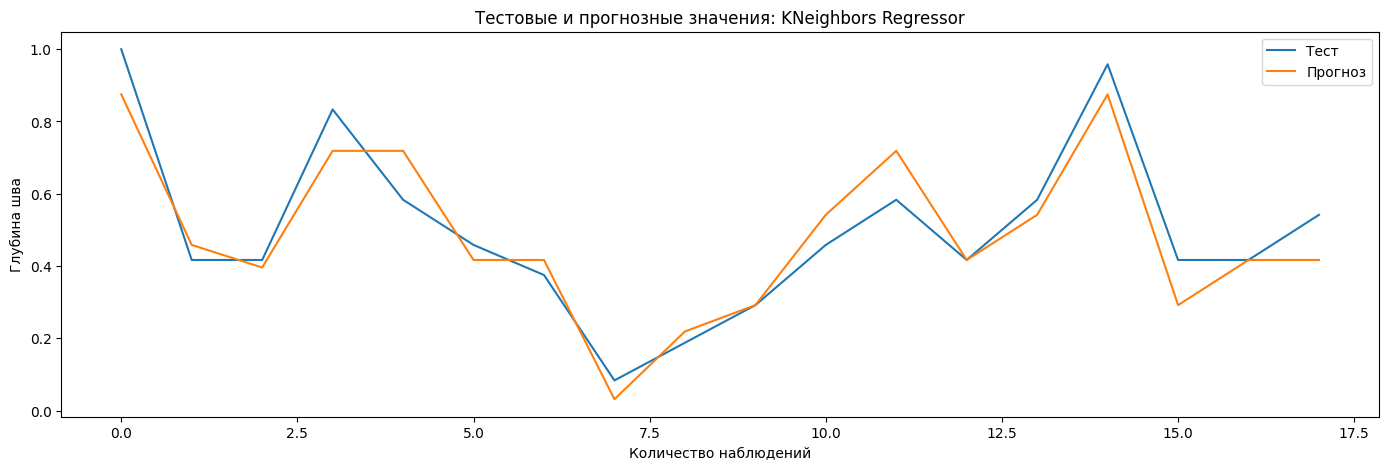

In [29]:
actual_and_predicted_plot(y_test_depth.values, 
neigh_d.predict(X_test_depth), 'Глубина шва', 'KNeighbors Regressor')

## 1.2) Для ширины

In [30]:
neigh_params = {'n_neighbors' : range(1, 101, 1), 'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}

GSCV_neigh_w = GridSearchCV(knr_model, neigh_params, n_jobs=-1, cv=10)
GSCV_neigh_w.fit(X_train_width, y_train_width)

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [ 0.72472554  0.72472554  0.70210057  0.69231421  0.64993185  0.72174956
  0.53411926  0.7125356   0.37468767  0.71028786  0.15076243  0.69275751
 -0.10608164  0.67531752 -0.27223938  0.6947659  -0.45425275  0.6947659
 -0.22080565  0.6947659  -0.0474249   0.6947659   0.06522369  0.6947659
  0.13097033  0.6947659   0.19819742  0.6947659   0.22448949  0.6947659
  0.2776812   0.6947659   0.29464492  0.6947659   0.2854162   0.6947659
  0.27570215  0.6947659   0.26202032  0.6947659   0.24956961  0.6947659
  0.24529476  0.6947659   0.19912058  0.6947659   0.14754777  0.6947659
  0.05376066  0.6947659  -0.05422831  0.6947659  -0.15758269  0.6947659
 -0.09117217  0.6947659  -0.04716525  0.6947659  -0.16263002  0.6947659
 -0.3074183   0.6947659  -0.28367594  0.6947659  -0.28761972  0.6947659
 -0.31201118  0.6947659  -0.34071115  0.6947659  -0.359

GridSearchCV(cv=10, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': range(1, 101),
                         'weights': ['uniform', 'distance']})

In [31]:
neigh_w = GSCV_neigh_w.best_estimator_
neigh_w

KNeighborsRegressor(n_neighbors=1)

In [32]:
MSE_knn_w = mean_squared_error(y_test_width, neigh_d.predict(X_test_width))

R2_knn_w = r2_score(y_test_width, neigh_d.predict(X_test_width))

print(f'MSE_knn_w = {MSE_knn_w}\nR2_knn_w = {R2_knn_w}')

MSE_knn_w = 0.06418926464517836
R2_knn_w = 0.41885595493562233


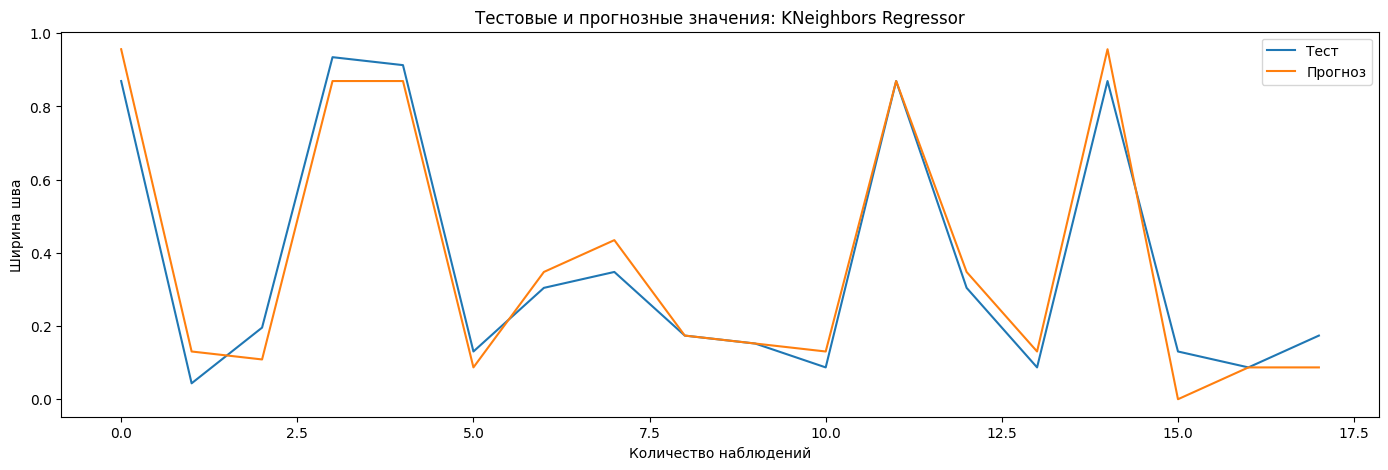

In [33]:
actual_and_predicted_plot(y_test_width.values, 
neigh_w.predict(X_test_width), 'Ширина шва', 'KNeighbors Regressor')

# 2) Алгоритм случайный лес

In [34]:
rf_model = RandomForestRegressor(random_state=42)


## 2.1) Для глубины

In [35]:
rf_model_params = {
 'n_estimators' : range(1, 100, 5),
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth' : range(1, 5, 1),
 'criterion':['mse']}
GSCV_rf_model_d = GridSearchCV(rf_model, rf_model_params, cv=5, verbose=2)
GSCV_rf_model_d.fit(X_train_depth, y_train_depth)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=6; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=11; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=81; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=81; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=81; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=81; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=86; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=86; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=86; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=86; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=56; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=96; total time=   0.2s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=56; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=96; total time=   0.2s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=81; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=86; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=46; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=51; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=56; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=56; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=56; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=1; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=11; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=86; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=51; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=81; total time=   0.2s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=86; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=86; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=86; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=86; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=96; total time=   0.2s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=96; total time=   0.2s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=51; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=51; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=56; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=56; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'criterion': ['mse'], 'max_depth': range(1, 5),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': range(1, 100, 5)},
             verbose=2)

In [36]:
rf_model_d = GSCV_rf_model_d.best_estimator_
rf_model_d

RandomForestRegressor(criterion='mse', max_depth=4, max_features='auto',
                      n_estimators=16, random_state=42)

In [37]:
MSE_rf_d = mean_squared_error(y_test_depth, rf_model_d.predict(X_test_depth))
R2_rf_d = r2_score(y_test_depth, rf_model_d.predict(X_test_depth))
print(f'MSE_rf_d = {MSE_rf_d}\nR2_rf_d = {R2_rf_d}')

MSE_rf_d = 0.009329389179701024
R2_rf_d = 0.8254767145698511


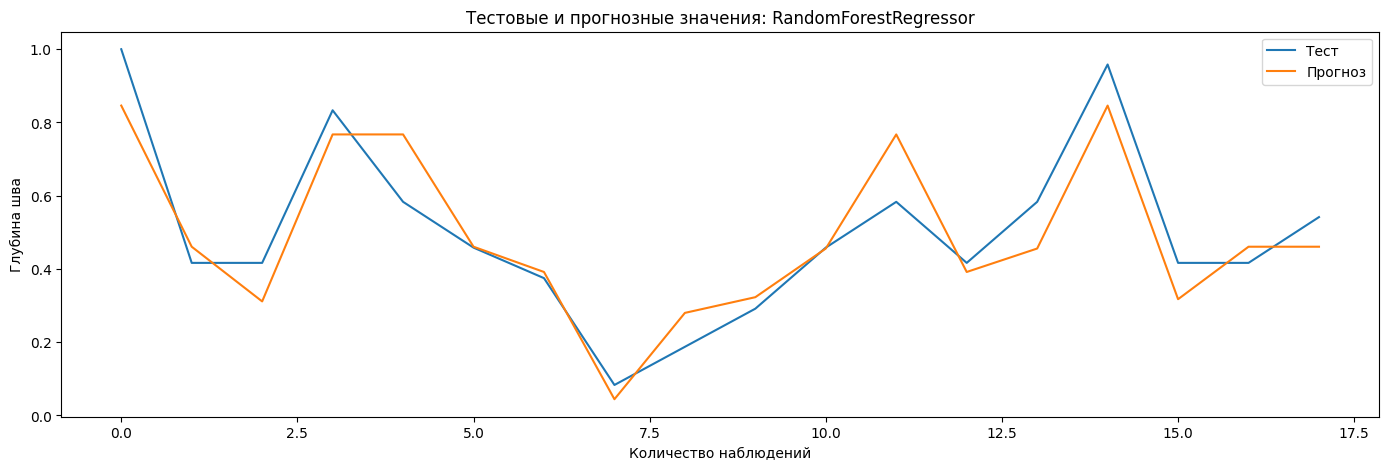

In [38]:
actual_and_predicted_plot(y_test_depth.values, 
rf_model_d.predict(X_test_depth), 'Глубина шва', 'RandomForestRegressor')

## 2.2) Для ширины

In [39]:
rf_model_params = {
 'n_estimators' : range(1, 100, 5),
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth' : range(1, 5, 1),
 'criterion':['mse']}
GSCV_rf_model_w = GridSearchCV(rf_model, rf_model_params, cv=5, verbose=2)
GSCV_rf_model_w.fit(X_train_width, y_train_width)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=6; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=51; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=auto, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=61; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=61; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=sqrt, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=1, max_features=log2, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=51; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=56; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=56; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=auto, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=sqrt, n_estimators=96; total time=   0.2s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=1; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=11; total time=   0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=56; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=2, max_features=log2, n_estimators=96; total time=   0.2s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=11; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=56; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=auto, n_estimators=96; total time=   0.2s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=sqrt, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=51; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=56; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=3, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=11; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=auto, n_estimators=96; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=86; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=91; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=sqrt, n_estimators=96; total time=   0.2s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=1; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=6; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=6; total time=   0.0

D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=11; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\e

[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=16; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=16; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=21; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=21; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=26; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=26; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=31; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=31; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=36; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=36; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=41; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=41; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=46; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=46; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=51; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=51; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=56; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=56; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=56; total time=   0.0s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=61; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=61; total time=   0.0s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=66; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=66; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=71; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=71; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=76; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=76; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=81; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=81; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=86; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=86; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=91; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=91; total time=   0.1s
[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=96; total time=   0.1s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END criterion=mse, max_depth=4, max_features=log2, n_estimators=96; total time=   0.2s


D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
D:\Downlad\Anaconda\envs\MGTU_DS\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'criterion': ['mse'], 'max_depth': range(1, 5),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': range(1, 100, 5)},
             verbose=2)

In [40]:
rf_model_w = GSCV_rf_model_w.best_estimator_
rf_model_w

RandomForestRegressor(criterion='mse', max_depth=4, max_features='auto',
                      n_estimators=71, random_state=42)

In [41]:
MSE_rf_w = mean_squared_error(y_test_width, rf_model_w.predict(X_test_width))
R2_rf_w = r2_score(y_test_width, rf_model_w.predict(X_test_width))
print(f'MSE_rf_w = {MSE_rf_w}\nR2_rf_w = {R2_rf_w}')

MSE_rf_w = 0.0029761434977988426
R2_rf_w = 0.9730551817260492


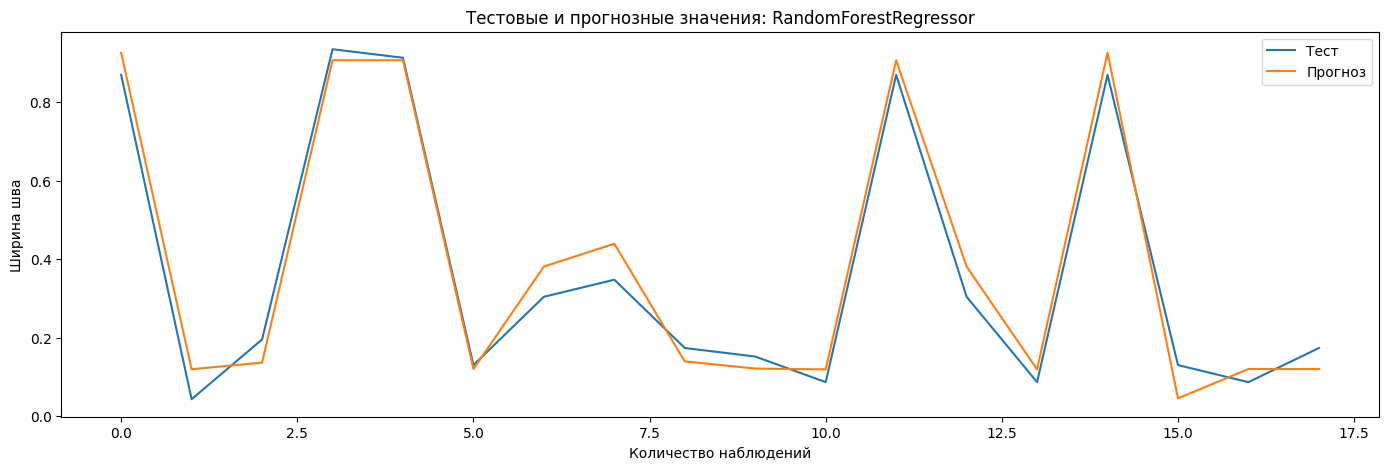

In [42]:
actual_and_predicted_plot(y_test_width.values, 
rf_model_w.predict(X_test_width), 'Ширина шва', 'RandomForestRegressor')

# 3) Нейронная сеть

In [43]:
# Построена 1 последовательная модель нейронной сети для прараметров ширины и глубины с двумя выходами.

In [57]:
model = Sequential()

#### 3.1)Разбиение на тестовые и обучающие выборки


In [58]:
#Выводится размерность выборок для контроля корректности разбиения
# Данные берутся из нормализованного в предыдущих шагах датасета (dn)

In [59]:
X = dn[['IW', 'IF', 'VW', 'FP']]

In [60]:
y = dn[['Depth', 'Width']]

In [61]:
X.shape,y.shape

((72, 4), (72, 2))

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=42)

In [63]:
print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(50, 4) (22, 4)
(50, 2) (22, 2)


#### 3.2) Добавление слоёвб компиляция и обучение нейросети

In [64]:
model.add(Dense(128, input_dim = 4, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(2, activation="relu"))

In [65]:
model.compile(optimizer = 'adam', loss='mean_squared_error') 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               640       
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 2)                 34        
                                                                 
Total params: 28,050
Trainable params: 28,050
Non-trai

In [66]:
model_hist = model.fit(X_train, y_train, epochs=100, verbose=1,validation_split = 0.2)

Epoch 1/100
2/2 [==============================] - 2s 386ms/step - loss: 0.1286 - val_loss: 0.1616
Epoch 2/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0879 - val_loss: 0.0641
Epoch 3/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0386 - val_loss: 0.0550
Epoch 4/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0347 - val_loss: 0.0229
Epoch 5/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0208 - val_loss: 0.0114
Epoch 6/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0140 - val_loss: 0.0152
Epoch 7/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0112 - val_loss: 0.0145
Epoch 8/100
2/2 [==============================] - 0s 62ms/step - loss: 0.0129 - val_loss: 0.0110
Epoch 9/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0120 - val_loss: 0.0107
Epoch 10/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0101 - val_loss: 0.0088
Epoch 11/100
2/2 [

#### 3.3) Оценка модели

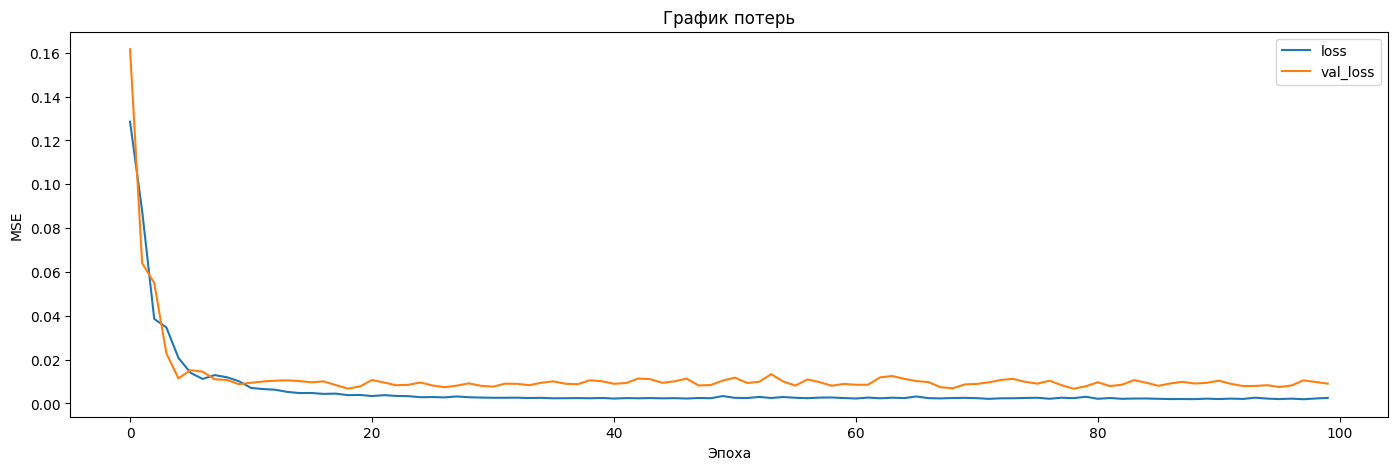

In [67]:
def model_loss_plot(model_hist):
    plt.figure(figsize=(17,5))
    plt.plot(model_hist.history['loss'])
    plt.plot(model_hist.history['val_loss'])
    plt.title('График потерь')
    plt.ylabel('MSE')
    plt.xlabel('Эпоха')
    plt.legend(['loss', 'val_loss'], loc='best')
    plt.show()
model_loss_plot(model_hist)

#### 3.3.1) Для глубины и ширины

1/1 [==============================] - 0s 204ms/step


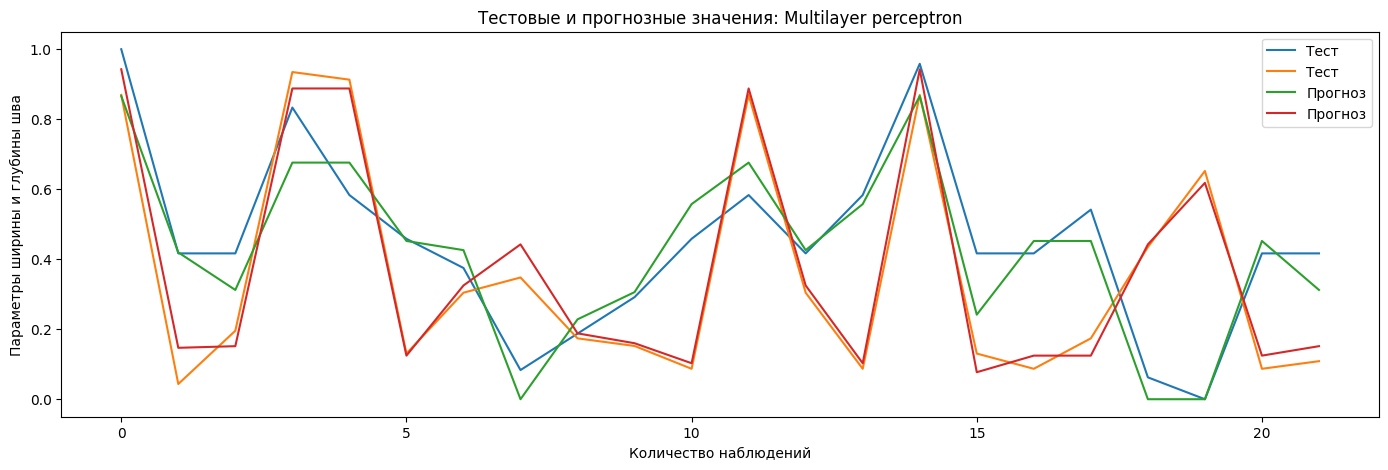

In [68]:
actual_and_predicted_plot(y_test.values, model.predict(X_test.values),'Параметры ширины и глубины шва', 'Multilayer perceptron')


In [69]:
MSE = mean_squared_error(y_test, model.predict(X_test.values))
R2 = r2_score(y_test, model.predict(X_test.values))
print(f'MSE = {MSE}\n R2 = {R2}')

1/1 [==============================] - 0s 39ms/step
MSE = 0.004672174786854477
 R2 = 0.9314642789173267


#### 3.3.2) Для глубины 

1/1 [==============================] - 0s 41ms/step


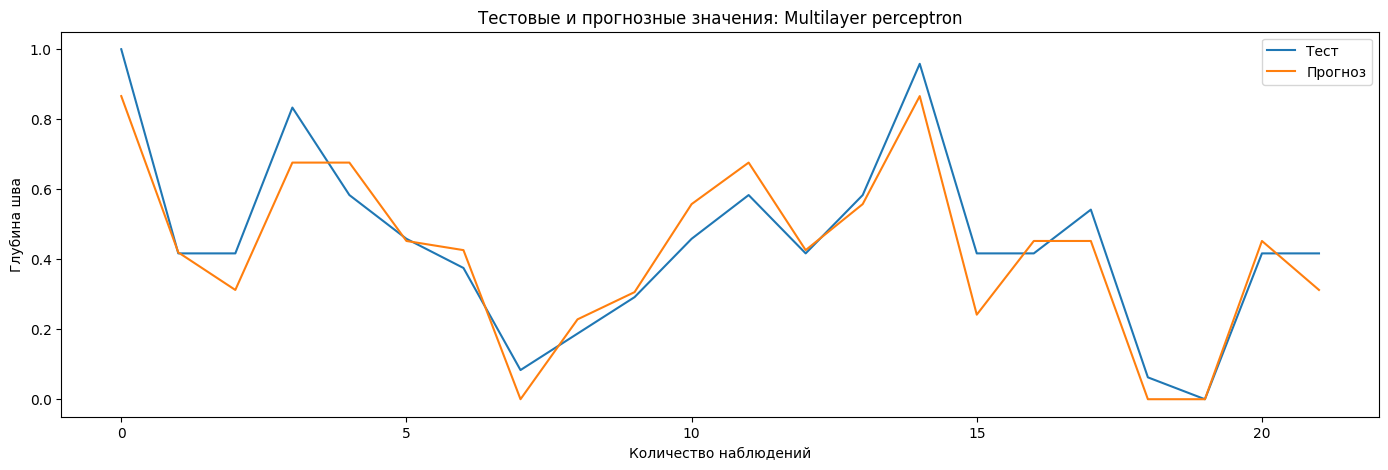

In [70]:
actual_and_predicted_plot(y_test.values[:,0], model.predict(X_test.values)[:,0],'Глубина шва', 'Multilayer perceptron')


In [71]:
MSE_n_d = mean_squared_error(y_test.iloc[:,0], model.predict(X_test.values)[:,0])
R2_n_d = r2_score(y_test.iloc[:,0], model.predict(X_test.values)[:,0])
print(f'MSE_n_d = {MSE_n_d}\n R2_n_d = {R2_n_d}')

1/1 [==============================] - 0s 40ms/step
MSE_n_d = 0.007151249486578363
 R2_n_d = 0.8846732263049539


#### 3.3.3) Для ширины

1/1 [==============================] - 0s 45ms/step


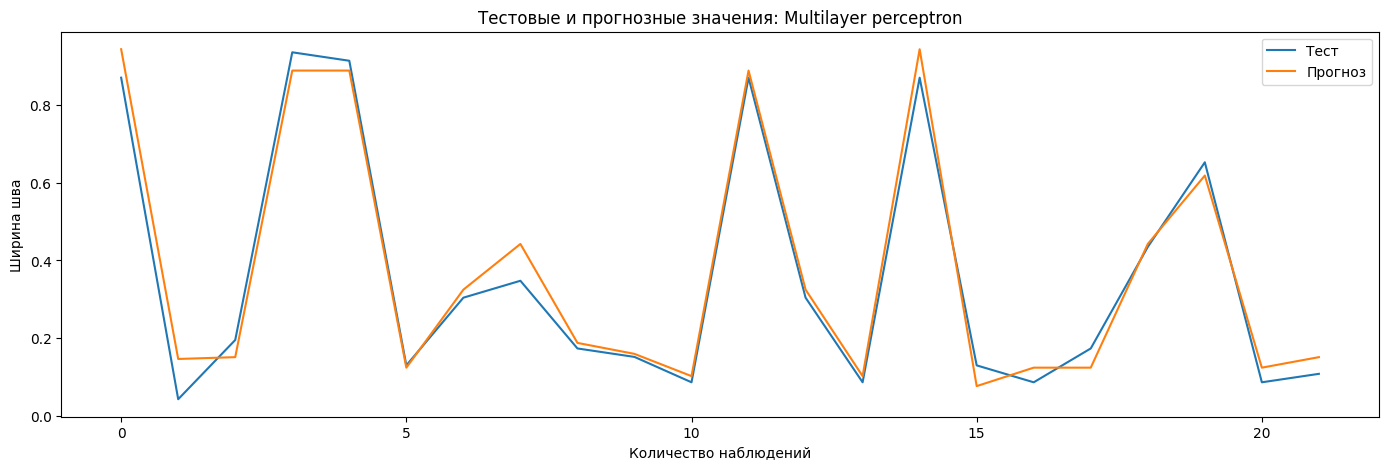

In [73]:
actual_and_predicted_plot(y_test.values[:,1], model.predict(X_test.values)[:,1],'Ширина шва', 'Multilayer perceptron')

In [74]:
MSE_n_w = mean_squared_error(y_test.iloc[:,1], model.predict(X_test.values)[:,1])
R2_n_w = r2_score(y_test.iloc[:,1], model.predict(X_test.values)[:,1])
print(f'MSE_n_w = {MSE_n_w}\n R2_n_w = {R2_n_w}')

1/1 [==============================] - 0s 40ms/step
MSE_n_w = 0.002193100087130591
 R2_n_w = 0.9782553315296996
